<a href="https://colab.research.google.com/github/DIFACQUIM/De-Novo_DNMT1/blob/main/t_SNE_fingerprints(MACCS%2CECFP4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Install rdkit
      !pip -q install rdkit
      pbar.update(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [76]:
#Import libraries
import pandas as pd
import numpy as np

import rdkit
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import Descriptors, PandasTools, AllChem, MACCSkeys, Pharm2D
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from scipy.spatial.distance import pdist

import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
#De novo compounds
df=pd.read_csv("https://raw.githubusercontent.com/DIFACQUIM/De-Novo_DNMT1/main/alvaBuilder/Alva2023_5575.csv", delimiter=",")
print(df.shape)
df.head(2)

(5575, 9)


,SMILES,DATABASE,ID,PROGRAM,FRAGMENTS,DATASET,PROGRAM_SCORE,SMILES_chiral,SMILES_no_chiral
0,OCCCNC(=O)c1cc(nc2cc(n[n]12)C(F)(F)F)-c1ccco1,AB_CDDNMT,ABCDT01_01,AlvaBuilder,ChemDiv DNMT,AB_CDDNMT01,1,O=C(NCCCO)c1cc(-c2ccco2)nc2cc(C(F)(F)F)nn12,O=C(NCCCO)c1cc(-c2ccco2)nc2cc(C(F)(F)F)nn12
1,CC(O)C(=O)OCN=C1NC(=Nc2ccccc12)c1cc(ccc1Br)OC(...,AB_CDDNMT,ABCDT01_02,AlvaBuilder,ChemDiv DNMT,AB_CDDNMT01,1,CC(=O)C(O)OCN=c1[nH]c(-c2cc(OC(=O)O)ccc2Br)nc2...,CC(=O)C(O)OCN=c1[nH]c(-c2cc(OC(=O)O)ccc2Br)nc2...


In [78]:
#DNMT1 actives
DNMT=pd.read_csv("https://github.com/DIFACQUIM/De-Novo_DNMT1/raw/main/DNMT1_10micM_285_curated.csv", delimiter=",")
DNMT.head(2)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,NEW_SMILES
0,CHEMBL3087498,NaN,0,618.58,1,3.61,SGC0946,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL4477246,1,Scientific Literature,Bioorg Med Chem Lett,2016.0,NaN,NaN,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...
1,CHEMBL2171169,NaN,0,540.67,1,2.25,FED1,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL4477246,1,Scientific Literature,Bioorg Med Chem Lett,2016.0,NaN,NaN,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cn...


In [79]:
#Add Database column for identification
DNMT['DATABASE'] = "DNMT1"

In [80]:
#List columns of both dataframes
print(df.columns)
print(DNMT.columns)

Index(['SMILES', 'DATABASE', 'ID', 'PROGRAM', 'FRAGMENTS', 'DATASET',
       'PROGRAM_SCORE', 'SMILES_chiral', 'SMILES_no_chiral'],
      dtype='object')
Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Sou

In [81]:
# Select columns
df = df[['ID', 'SMILES_chiral', 'DATABASE']]
DNMT = DNMT[['Molecule ChEMBL ID', 'NEW_SMILES', 'DATABASE']]

# Change names
df.columns = ["ID", "SMILES", "DATABASE"]
DNMT.columns = ["ID", "SMILES", "DATABASE"]

#Concatenate
DATA = pd.concat([DNMT, df], sort=False)
print(DATA.shape)
DATA.head()

(5860, 3)


,ID,SMILES,DATABASE
0,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...,DNMT1
1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cn...,DNMT1
2,CHEMBL83747,O=C(NCCSSCCNC(=O)C(Cc1ccc(O)c(Br)c1)=NO)C(Cc1c...,DNMT1
3,CHEMBL4215326,COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(C)o3)[nH]c2cc...,DNMT1
4,CHEMBL1201129,N=c1ncn(C2CC(O)C(CO)O2)c(=O)[nH]1,DNMT1


In [82]:
df_ECFP4 = pd.DataFrame([[int(y) for y in AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2, nBits=1024).ToBitString()] for x in DATA["SMILES"]])

In [83]:
df_ECFP4.head(2)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [84]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
data_tsne = df_ECFP4.copy()
data_tsne = StandardScaler().fit_transform(data_tsne)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(data_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5860 samples in 0.034s...
[t-SNE] Computed neighbors for 5860 samples in 4.565s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5860
[t-SNE] Computed conditional probabilities for sample 2000 / 5860
[t-SNE] Computed conditional probabilities for sample 3000 / 5860
[t-SNE] Computed conditional probabilities for sample 4000 / 5860
[t-SNE] Computed conditional probabilities for sample 5000 / 5860
[t-SNE] Computed conditional probabilities for sample 5860 / 5860
[t-SNE] Mean sigma: 11.622554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.065826
[t-SNE] KL divergence after 1000 iterations: 2.541564


In [85]:
label = DATA[["DATABASE", "ID", "SMILES"]]
label = label.to_numpy()

In [86]:
# Concatenate arrays
arr = np.concatenate((label, tsne_results), axis = 1)

In [87]:
# New dataframe
tsne_dataset = pd.DataFrame(data=arr, columns = ['DATABASE','ID', 'SMILES','dimension1', 'dimension2'] )
tsne_dataset.head(2)

,DATABASE,ID,SMILES,dimension1,dimension2
0,DNMT1,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...,-46.332363,55.31636
1,DNMT1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cn...,-46.350349,55.362061


<Figure size 640x480 with 0 Axes>

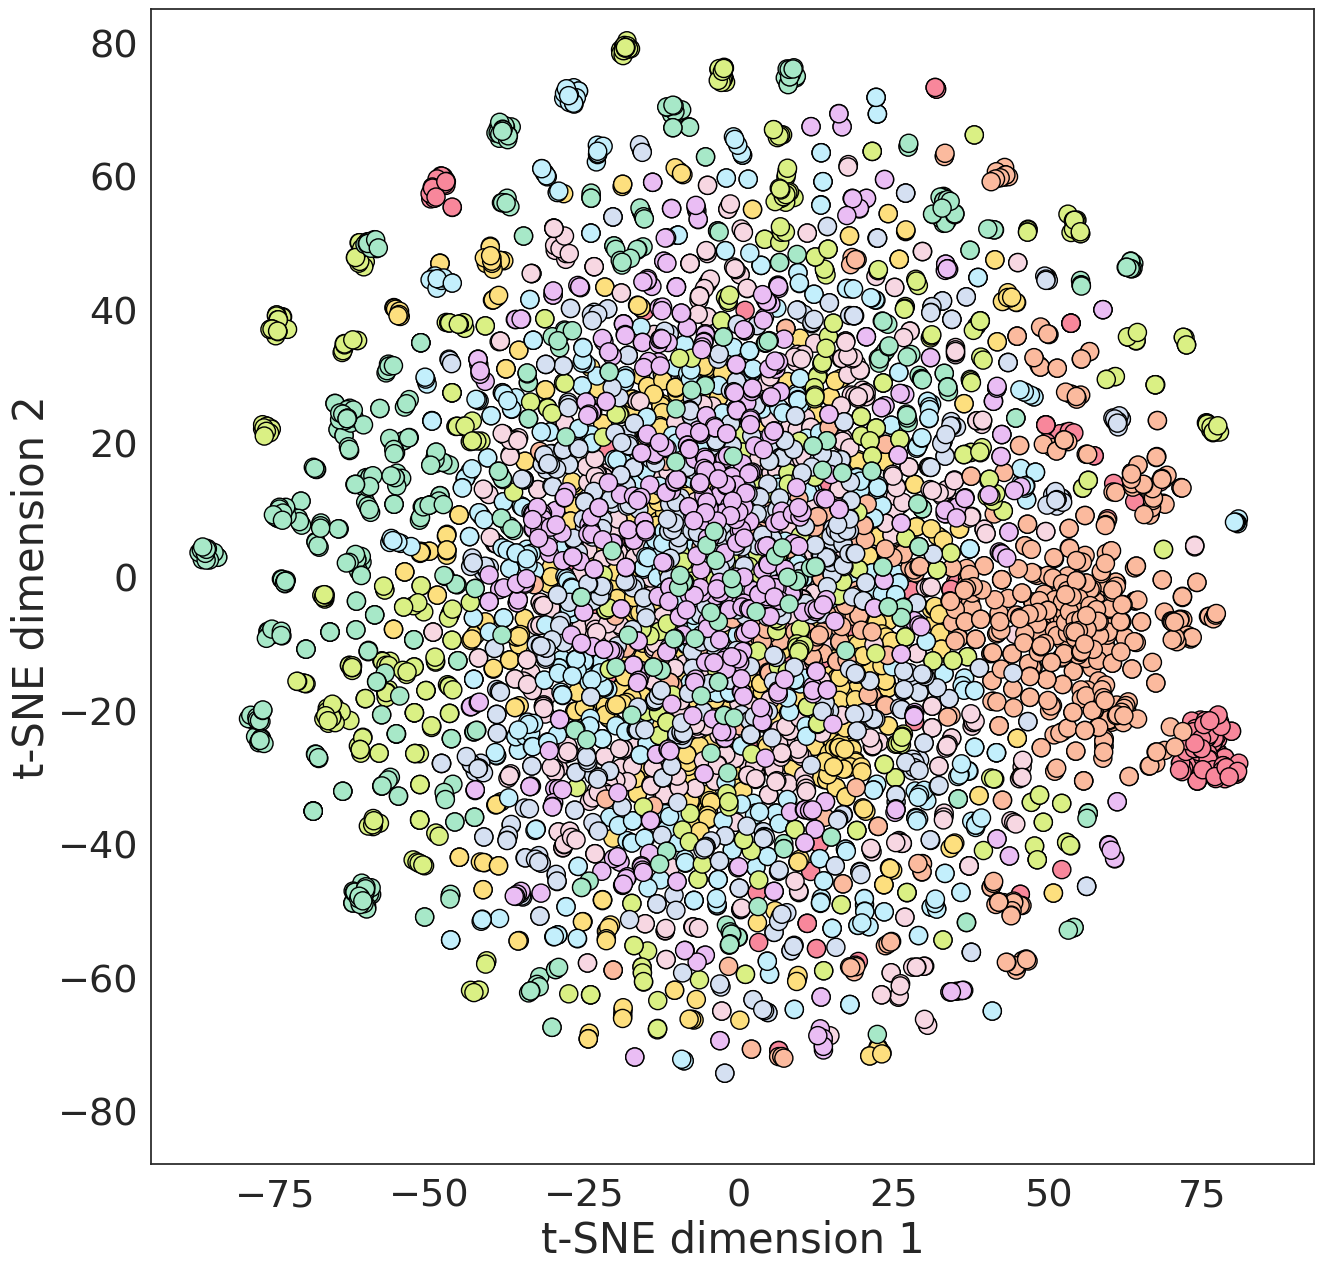

In [88]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = tsne_dataset["dimension1"],
                y = tsne_dataset["dimension2"],
                hue = tsne_dataset["DATABASE"], #Label
                palette=['#F8879B', '#FDDF7E', '#F7D7E2', '#C3EFFC', '#FBBA9E', '#DAF084', '#D5E0F2', '#EABDF4', '#A7E8C8'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 85)
ax.collections[0].set_sizes([170])

plt.legend().remove()

#plt.savefig('alva_tSNE_ECFP4.png', bbox_inches = 'tight', dpi=400)

In [103]:
#Select one database
DNMT1 = tsne_dataset[tsne_dataset["DATABASE"].str.contains("DNMT1")]
CDDNMT = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_CDDNMT")]
CDEPI = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_CDEPI")]
CDSOL = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_CDSOL")]
ABDNMT = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_DNMT1")]
FOODB = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_FOODB")]
LCDIV = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_LCDIV")]
LCEPI = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_LCEPI")]
UNPDA = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_UNPDA")]

<Figure size 640x480 with 0 Axes>

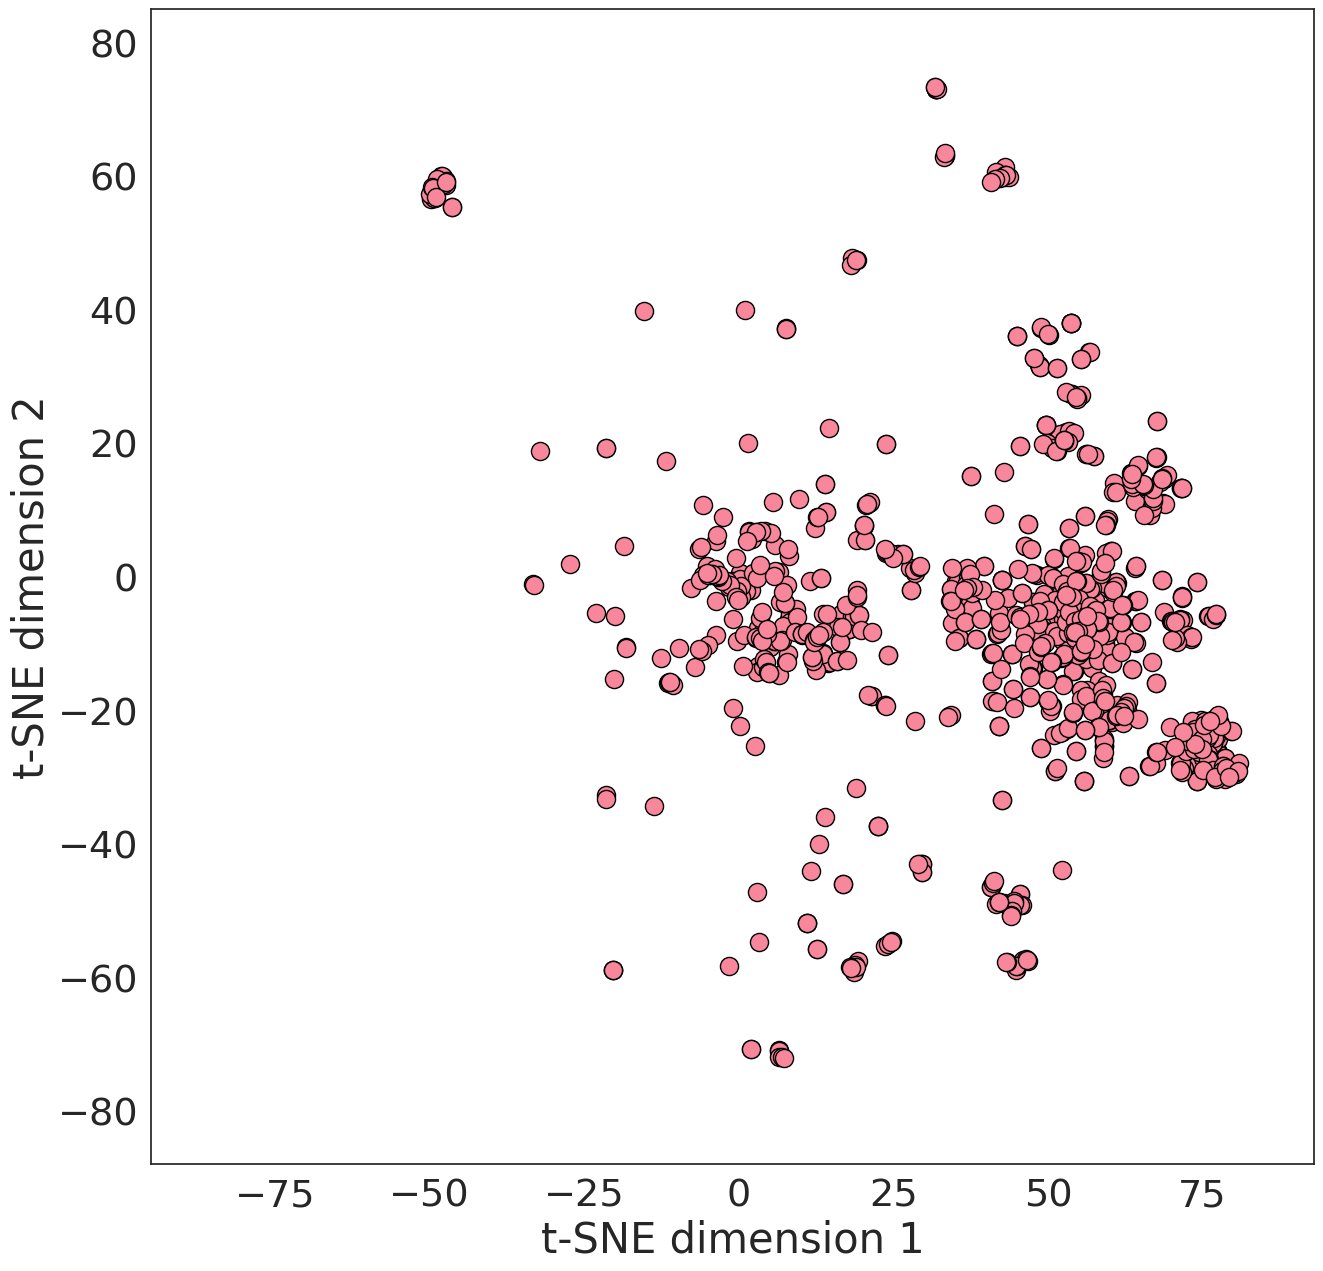

In [105]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = DNMT1["dimension1"],
                y = DNMT1["dimension2"],
                color= '#F8879B',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 85)
ax.collections[0].set_sizes([170])

plt.legend().remove()

#plt.savefig('alva_tSNE_ECFP4_1.png', bbox_inches = 'tight', dpi=400)

In [94]:
#MACCS Keys
df_MACCS_Keys=pd.DataFrame([[int(y) for y in MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)).ToBitString()] for x in DATA["SMILES"]])

In [95]:
data_tsne_2 = df_MACCS_Keys.copy()
data_tsne_2 = StandardScaler().fit_transform(data_tsne_2)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results_2 = tsne.fit_transform(data_tsne_2)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5860 samples in 0.003s...
[t-SNE] Computed neighbors for 5860 samples in 0.616s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5860
[t-SNE] Computed conditional probabilities for sample 2000 / 5860
[t-SNE] Computed conditional probabilities for sample 3000 / 5860
[t-SNE] Computed conditional probabilities for sample 4000 / 5860
[t-SNE] Computed conditional probabilities for sample 5000 / 5860
[t-SNE] Computed conditional probabilities for sample 5860 / 5860
[t-SNE] Mean sigma: 4.161596
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.336411
[t-SNE] KL divergence after 1000 iterations: 1.769520


In [96]:
label = DATA[["DATABASE", "ID", 'SMILES',]]
label = label.to_numpy()
arr_2 = np.concatenate((label, tsne_results_2), axis = 1)

In [97]:
# New dataframe
tsne_dataset_2 = pd.DataFrame(data=arr_2, columns=["DATABASE", "ID", "SMILES",'dimension1', 'dimension2'] )
tsne_dataset_2.head(2)

,DATABASE,ID,SMILES,dimension1,dimension2
0,DNMT1,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...,-11.06883,-4.31671
1,DNMT1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cn...,-11.063675,-4.295079


<Figure size 640x480 with 0 Axes>

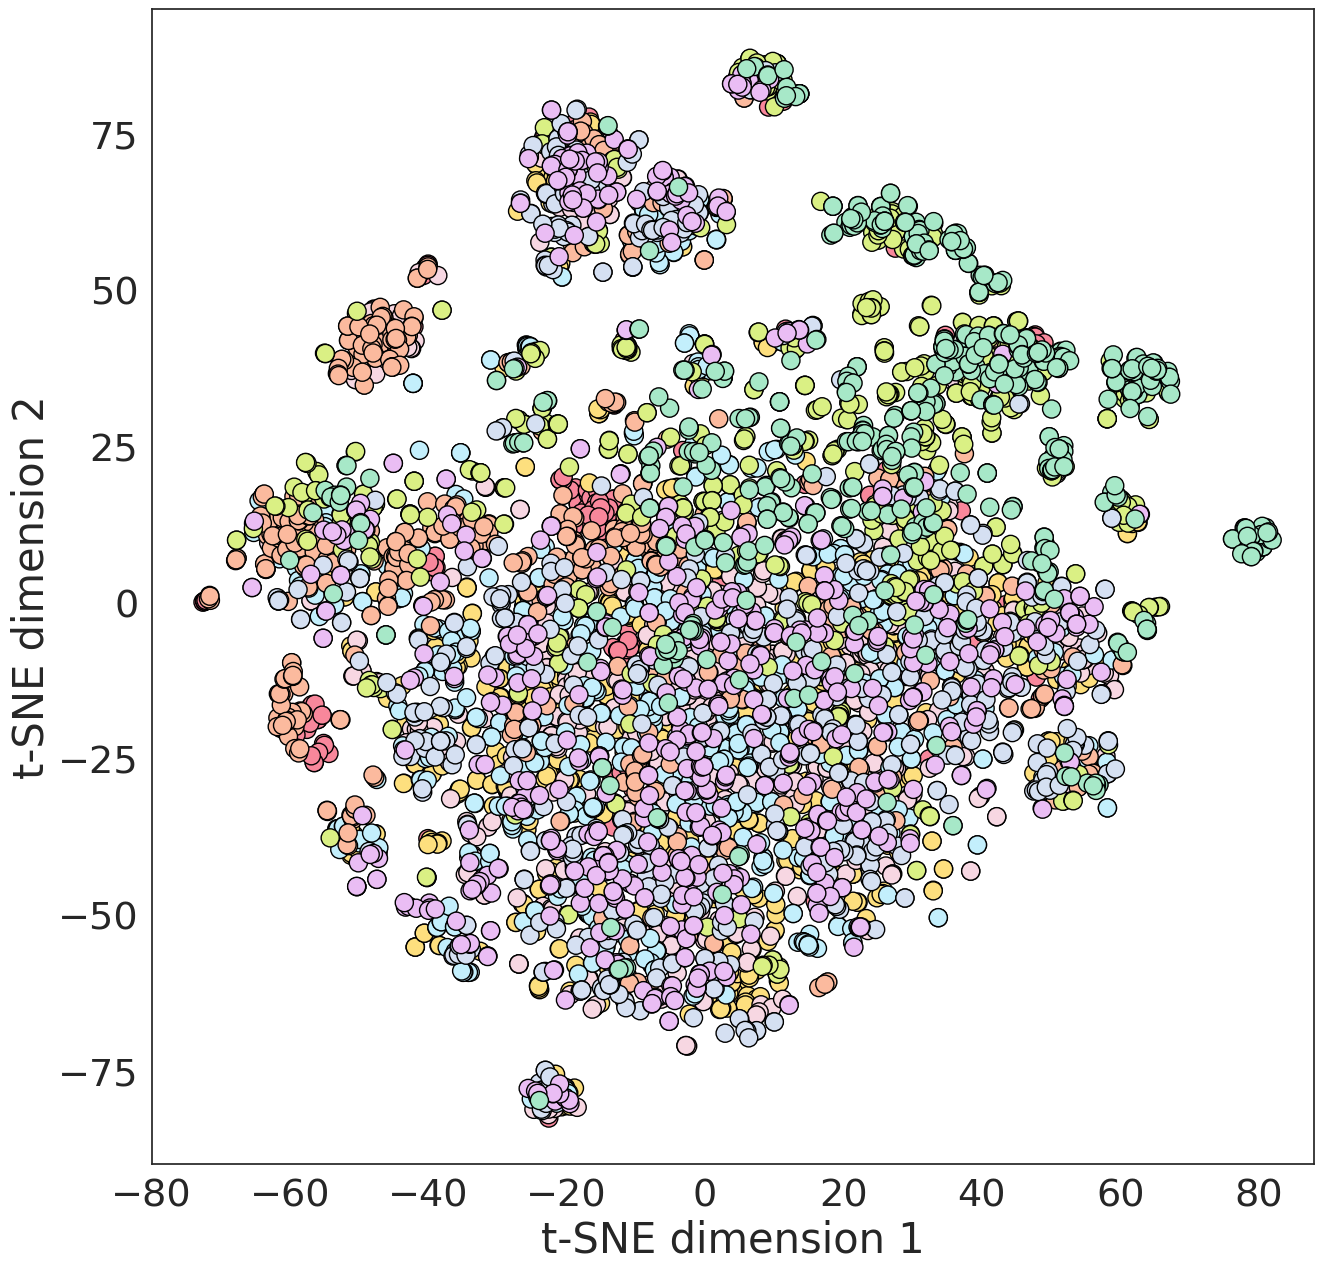

In [102]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = tsne_dataset_2["dimension1"],
                y = tsne_dataset_2["dimension2"],
                hue = tsne_dataset_2["DATABASE"], #Label
                palette=['#F8879B', '#FDDF7E', '#F7D7E2', '#C3EFFC', '#FBBA9E', '#DAF084', '#D5E0F2', '#EABDF4', '#A7E8C8'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 88)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

#plt.savefig('alva_tSNE_MACCS.png', bbox_inches = 'tight', dpi=400)